# QSAR: Quantitative Structure-Activity Relationships 

In [1]:
# Importing the necessary libraries and defining the base URL for the CHEMBL API:
# Data management and visualization
import json # To work with json format
import requests # To make web requests
import pandas as pd # To work with pandas dataframes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Rdkit library functions
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, AllChem, MACCSkeys
# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
base_url = "https://www.ebi.ac.uk/chembl/api/data/{:s}" # Base URL for Chembl API

## DATASET

In the process of selecting candidate PARP1 inhibitor molecules I have developed a QSAR by training the to perform a prediction of the IC50 value of the selected molecules from the Ligan Based Virtual Screening process.

In [2]:
# pARP1 human UNIPROT code: P09874
parp1_url = base_url.format("target_component?accession=P09874") # defining the enzime by its UniProt ID
parp1_components = requests.get(parp1_url, headers={"Accept":"application/json"}).json()['target_components'] # Get request to the CHEMBL API to retrieve CHEMBL ID
parp1_components[0]['targets']

[{'target_chembl_id': 'CHEMBL3105'},
 {'target_chembl_id': 'CHEMBL3390820'},
 {'target_chembl_id': 'CHEMBL4742271'},
 {'target_chembl_id': 'CHEMBL4748223'}]

The first result obtained with CHEMBL3105 corresponds to the single protein of Poly [ADP-ribose] polymerase-1 (PARP-1), so it is the one selected to search for compounds that may interact with this protein and have established IC50 values and therefore may have inhibitory capacity to be able to train the model.

The search is performed using paging to obtain a large number of compounds in the hope of obtaining the highest representation of IC50 values and to be able to have a balanced dataset.

A total of 3096 compounds are obtained.

In [3]:
chembl_id = parp1_components[0]['targets'][0]['target_chembl_id'] # CHEMBL3105 SSTR2
num_pages=7 # two dataframes
page_size=1000 # size of dataframes
all_data=[]
for page in range(1, num_pages + 1):
    offset = (page - 1) * page_size
    activity_url = base_url.format(f"activity?target_chembl_id__exact={chembl_id}&limit={page_size}&offset={offset}&type=IC50") # parameters of our query, searching by IC50
    response = requests.get(activity_url, headers={"Accept": "application/json"}) # get request to the ChemBL database
    if response.status_code == 200:
        activity_request = response.json()
        data = activity_request.get('activities', [])
        all_data.extend(data)
    else:
        print(f"Error in the request ({response.status_code}): {response.text}")
molec_db = pd.DataFrame.from_dict(all_data)
molec_db_filtered = molec_db[molec_db['standard_units'] == 'nM'][['molecule_chembl_id', 'type', 'standard_value', 'standard_units', 'canonical_smiles']]
print(molec_db_filtered)

     molecule_chembl_id  type standard_value standard_units  \
0          CHEMBL110347  IC50         5000.0             nM   
1          CHEMBL108702  IC50           20.0             nM   
2          CHEMBL418816  IC50         3000.0             nM   
3          CHEMBL108968  IC50           30.0             nM   
4          CHEMBL430707  IC50           35.0             nM   
...                 ...   ...            ...            ...   
3190      CHEMBL5209870  IC50            4.6             nM   
3191      CHEMBL5197463  IC50          197.0             nM   
3192       CHEMBL521686  IC50            8.0             nM   
3193      CHEMBL1173055  IC50            0.8             nM   
3194      CHEMBL4533690  IC50           13.3             nM   

                                       canonical_smiles  
0     CC(CC(=O)NCC(=O)c1ccc2ccccc2c1)n1c2c(c(=O)[nH]...  
1     Nc1cccc(-c2ccc(C(=O)CNC(=O)CCn3c4c(c(=O)[nH]c3...  
2     O=C(CCn1c2c(c(=O)[nH]c1=O)CCC2)NCC(=O)N1CCN(c2...  
3     O=C(C

They are sorted by ascending IC50 values and I have decided to remove the query compound from the Virtual Screening as it will be evaluated as a model control (it is within the 718 compounds selected above). 

If it were not eliminated, a bias would be introduced in the model when the prediction is made with the compounds of interest since this would be a data with which the model would have been trained so it would make a good prediction of its IC50 and surely it would not be the real one predicted by the model (with the real accuracy that is achieved once trained).

On the other hand, it is inconvenient since this is the only compound that presents an IC50 value lower than 0.1 nM, so the model will not be trained with this range of IC50 values.
Therefore, it is not expected to be able to predict such low values (very high inhibition potency).

In [4]:
molec_db_filtered['standard_value'] = molec_db_filtered['standard_value'].astype(float)
molec_db = molec_db_filtered.sort_values(by = 'standard_value', ascending = True).dropna().reset_index(drop=True)
molec_db.head()

,molecule_chembl_id,type,standard_value,standard_units,canonical_smiles
0,CHEMBL4169012,IC50,0.02,nM,N#Cc1ccccc1N1CCN(C(=O)c2cc(Cc3n[nH]c(=O)c4cccc...
1,CHEMBL4161087,IC50,0.10,nM,Cc1ccc(N2CCN(C(=O)c3cc(Cc4n[nH]c(=O)c5ccccc45)...
2,CHEMBL4170665,IC50,0.10,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN...
3,CHEMBL4845834,IC50,0.19,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(c2...
4,CHEMBL4159834,IC50,0.20,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN...


In [5]:
# I search the index of the row where the column 'molecule_chembl_id' is equal to 'CHEMBL4169012'.
index_to_drop = molec_db.loc[molec_db['molecule_chembl_id'] == 'CHEMBL4169012'].index

# I remove this row from the dataframe
molec_db.drop(index_to_drop, inplace=True)

In [6]:
molec_db.head()

,molecule_chembl_id,type,standard_value,standard_units,canonical_smiles
1,CHEMBL4161087,IC50,0.10,nM,Cc1ccc(N2CCN(C(=O)c3cc(Cc4n[nH]c(=O)c5ccccc45)...
2,CHEMBL4170665,IC50,0.10,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN...
3,CHEMBL4845834,IC50,0.19,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(c2...
4,CHEMBL4159834,IC50,0.20,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN...
5,CHEMBL63354,IC50,0.20,nM,O=c1cc(-c2ccc(O)c(-c3c(O)cc(O)c4c(=O)cc(-c5ccc...


## Dataset cleaning

In [7]:
# Addtionally, remove those compounds with IC50=0.0 cM as this might be the result of inability to detect any inhibitory activity
# We should focus on those compounds with confirmed structure-activity relationships
molec_db['standard_value'] = molec_db['standard_value'].astype(float)
molec_db = molec_db[molec_db['standard_value'] != 0.0].copy()
len(molec_db)

3095

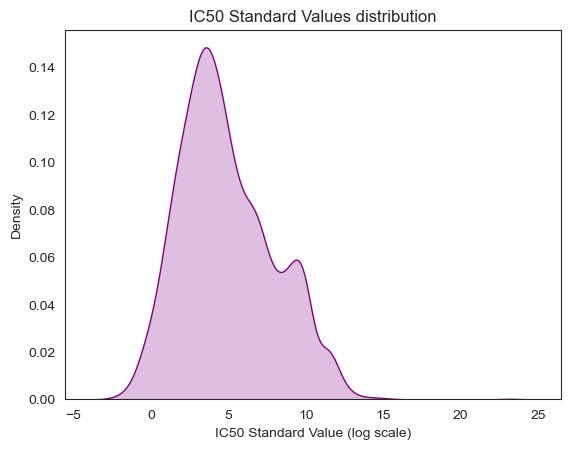

In [8]:
molec_db['standard_value'] = molec_db['standard_value'].astype(float) #convert the IC50 value column from string to float type
sns.set_style("white")
sns.kdeplot(np.log(molec_db['standard_value']), color='purple', fill=True)
plt.title('IC50 Standard Values distribution')
plt.xlabel('IC50 Standard Value (log scale)')
plt.ylabel('Density')
plt.show()

After observing the density of the logarithmic IC50 values of the compounds in the dataset, it was decided to filter the database with a maximum threshold of 12500 nM IC50.

In [9]:
molec_db = molec_db[molec_db['standard_value'] <= 12000.0].copy()
len(molec_db)

2796

With this measure, a more balanced database can be observed to which different pre-processing stages will continue to be carried out.

Text(0.5, 0, 'IC50 Standard Value (log scale)')

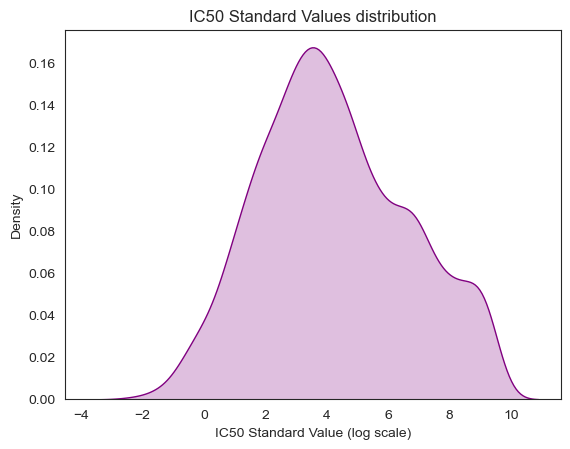

In [10]:
molec_db['standard_value'] = molec_db['standard_value'].astype(float) #convert the IC50 value column from string to float type
sns.set_style("white")
sns.kdeplot(np.log(molec_db['standard_value']), color='purple', fill=True)
plt.title('IC50 Standard Values distribution')
plt.xlabel('IC50 Standard Value (log scale)')

In [11]:
# Firslty, lets remove any missing values
molec_db = molec_db.dropna().reset_index(drop=True)
len(molec_db)

2796

In [12]:
# Also, remove those compounds containing charges to reduce bias in our model due to charges influencing their biological activity
molec_db_cleaned = molec_db[molec_db['canonical_smiles'].apply(lambda x:all(atom.GetFormalCharge() == 0 for atom in Chem.MolFromSmiles(x).GetAtoms()))].reset_index(drop=True)
len(molec_db_cleaned)

2766

In [13]:
# Remove compounds with metal elements so the coordination of these elements does not influence activity prediction by filtering
def get_metals(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for at in mol.GetAtoms():
        # Lithium Beryllium Sodium Magnesium Aluminum Potassium...
        if (at.GetAtomicNum() == 3) or (at.GetAtomicNum() == 4) or ((at.GetAtomicNum() >= 11) and (at.GetAtomicNum() <= 13)) or (at.GetAtomicNum()>= 19):
            return True
        return False

In [14]:
molec_db_cleaned = molec_db_cleaned[~molec_db_cleaned['canonical_smiles'].apply(lambda x: get_metals(x))].copy()
len(molec_db_cleaned)

2762

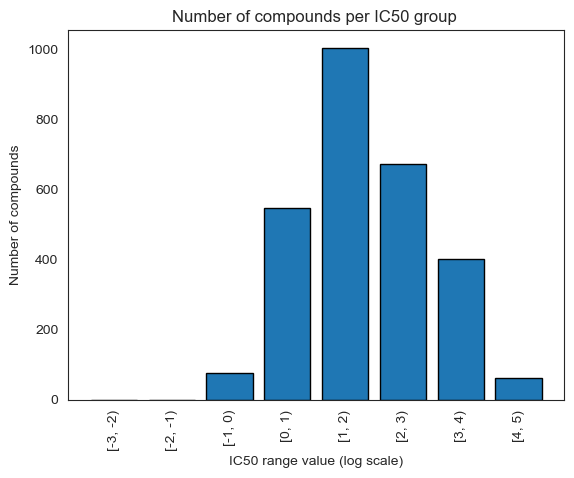

In [15]:
# Now, we will create groups of compounds based on their IC50 value by defining specific ranges and count the number of compounds in every "inhibition activity class"
# These would allow us to create a balanced database with compounds with different activity power
ic50_ranges = [-3, -2, -1, 0, 1, 2 ,3 ,4, 5] # ranges in a logarithm fashion
bins = pd.cut(np.log10(molec_db_cleaned['standard_value']), bins=ic50_ranges,right=False) # Assign each compount to an interval
ranged_counts = molec_db_cleaned.groupby(bins)['standard_value'].count() # Group and count occurences in each group
plt.bar(ranged_counts.index.astype(str), ranged_counts, edgecolor='black')
plt.xlabel('IC50 range value (log scale)')
plt.ylabel('Number of compounds')
plt.title('Number of compounds per IC50 group ')
plt.xticks(rotation=90)
plt.show()

After observing the number of compounds in each IC50 logarithm range, I have decided to balance the dataset around 600 compounds for the ranges that exceed it with the intention of, for the ranges that present a greater number of compounds, not to have one overrepresented.

In [16]:
threshold = 600  # desired maximum number of instances
balanced_df = pd.DataFrame()

# Apply undersampling to classes exceeding the threshold
for ic50_range, count in ranged_counts.items():
    # Select all indices within the current IC50 range
    indices = molec_db_cleaned[(np.log10(molec_db_cleaned['standard_value']) >= ic50_range.left) & 
                               (np.log10(molec_db_cleaned['standard_value']) < ic50_range.right)].index
    # If the class size exceeds the threshold, undersample it to the threshold
    if count > threshold:
        undersampled_indices = molec_db_cleaned.loc[indices].sample(n=threshold, random_state=42).index
    else:
        undersampled_indices = indices
    # Concatenate the indices to the balanced DataFrame
    balanced_df = pd.concat([balanced_df, molec_db_cleaned.loc[undersampled_indices]]).reset_index(drop=True)

len(balanced_df)


2285

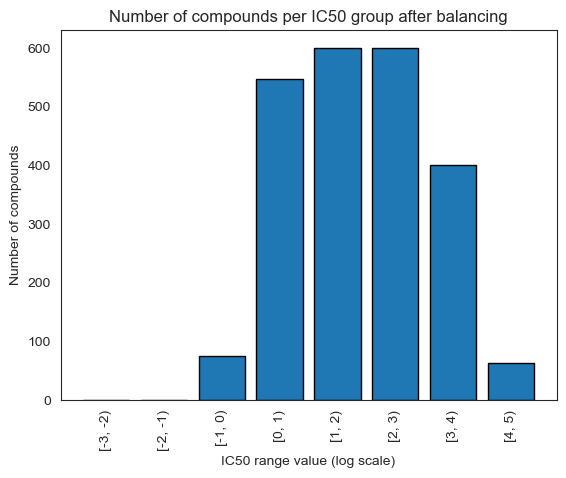

In [17]:
# Regroup the data of the balanced DataFrame
ic50_ranges = [-3, -2, -1, 0, 1, 2 ,3 ,4, 5] # ranges in a logarithm fashion
bins = pd.cut(np.log10(balanced_df['standard_value']), bins=ic50_ranges, right=False) # Assign each compound to an interval
ranged_counts_balanced = balanced_df.groupby(bins)['standard_value'].count() # Group and count occurrences in each group

plt.bar(ranged_counts_balanced.index.astype(str), ranged_counts_balanced, edgecolor='black')
plt.xlabel('IC50 range value (log scale)')
plt.ylabel('Number of compounds')
plt.title('Number of compounds per IC50 group after balancing')
plt.xticks(rotation=90)
plt.show()


## MACCS calculation

In this case the model prediction is going to be based only on MACCS and I have decided not to add ADMET properties since these properties (rule of 5) will be checked for compounds that have passed the filter by predicted IC50 value.

In [18]:
maccs_fingerprints_list = []
for smiles in balanced_df['canonical_smiles']: # Iterate through the SMILES feature and calculate descriptors
    mol = Chem.MolFromSmiles(smiles)
    # Get MACCS fingerprints to get all 167 bits as X variables (descriptors)
    maccs_fingerprints = AllChem.GetMACCSKeysFingerprint(mol)
    maccs_fingerprints_list.append(maccs_fingerprints)
df_maccs = pd.DataFrame(maccs_fingerprints_list) # A df should be created with MACCS peptide fingerprint info
df_maccs

,0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
2280,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2281,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2282,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2283,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
db_maccs_exp = pd.DataFrame(df_maccs[0].apply(list).tolist(),columns=[f'MACCS_{i+1}' for i in range(167)]) # Split MACCS fingerprint into individual columns
db = pd.concat([balanced_df, db_maccs_exp], axis=1) # Merge balanced original dataframe with DF with the descriptors
db

,molecule_chembl_id,type,standard_value,standard_units,canonical_smiles,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,MACCS_167
0,CHEMBL4161087,IC50,0.10,nM,Cc1ccc(N2CCN(C(=O)c3cc(Cc4n[nH]c(=O)c5ccccc45)...,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
1,CHEMBL4170665,IC50,0.10,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN...,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
2,CHEMBL4845834,IC50,0.19,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(c2...,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
3,CHEMBL4159834,IC50,0.20,nM,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)cc(F)c1F)N1CCN...,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
4,CHEMBL63354,IC50,0.20,nM,O=c1cc(-c2ccc(O)c(-c3c(O)cc(O)c4c(=O)cc(-c5ccc...,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,CHEMBL1767051,IC50,11200.00,nM,O=C(Nc1cccc2c(=O)[nH]ccc12)c1ccc(Cl)cc1,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
2281,CHEMBL81977,IC50,11200.00,nM,NC(=O)c1cccc(N)c1,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,0
2282,CHEMBL2322613,IC50,11230.00,nM,CN(C(=O)c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)C1CC...,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
2283,CHEMBL3617770,IC50,11292.00,nM,CC(C)NCc1ccc(-c2[nH]c3cccc4c3c2C(=O)NNC4=O)cc1,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


## Logarithm

Applying a logarithmic transformation would allow us to transform the relationship between the X variable (input features) and our model's response into a linear one. This would improve the model's performance by considering possible exponential relationships.

In [20]:
db['log_standard_value'] = np.log10(db['standard_value']) # usually, a base-10 logarithm is employed
# Define X variables by selecting features for our predictive model (descriptors)
X = db.drop(columns=['standard_value','log_standard_value', 'canonical_smiles','molecule_chembl_id', 'standard_units', 'type'])
Y = db['log_standard_value'] # The target variable (response variable)

In [21]:
Y

0      -1.000000
1      -1.000000
2      -0.721246
3      -0.698970
4      -0.698970
          ...   
2280    4.049218
2281    4.049218
2282    4.050380
2283    4.052771
2284    4.079181
Name: log_standard_value, Length: 2285, dtype: float64

## Train Test Split

In [22]:
 X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [23]:
len (X_train) # set of features for training the model

1828

In [24]:
len (X_test) # test set of feautres to evaluate model's perfomance

457

## Model selection

I have used these 4 algorithms to choose the one with the best performance for the type of work to be done.

In [58]:
 models = {
'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
'XGBoost': XGBRegressor(n_estimators=200,random_state=42),
'SVM': SVR(),
'Gradient Boosting Tree Method':GradientBoostingRegressor(n_estimators=200, random_state=42),
}

In [26]:
#Dictionary to store results and predictions
results = {}
predictions = {}
# Pipeline to perform model training and testing with several algorithms
for model_name, model in models.items():
    model.fit(X_train, Y_train) # Train the model
    Y_pred = model.predict(X_test) # Make predictions
    predictions[model_name] = Y_pred
    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
    pearson_corr = np.corrcoef(Y_test, Y_pred)[0, 1]
    mae = mean_absolute_error(Y_test, Y_pred)
    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Pearson Correlation Coefficient': pearson_corr,
        'MAE': mae
        }

In [27]:
# -------- Print evaluation results --------------------------
for model_name, metrics in results.items():
    print(f'\n{model_name} Metrics:')
    for metric, value in metrics.items():
        print(f'{metric}: {value}')


Random Forest Metrics:
MSE: 0.48223479381755635
RMSE: 0.6944312736459645
R2 Score: 0.6154091352665148
Pearson Correlation Coefficient: 0.785390012668613
MAE: 0.4987280871743623

XGBoost Metrics:
MSE: 0.4711688263769533
RMSE: 0.6864173849611862
R2 Score: 0.624234442029229
Pearson Correlation Coefficient: 0.7957069907311036
MAE: 0.4953853203785174

SVM Metrics:
MSE: 0.5724418644762416
RMSE: 0.7565988795103
R2 Score: 0.5434673845789366
Pearson Correlation Coefficient: 0.7406673018345065
MAE: 0.5564061761877942

Gradient Boosting Tree Method Metrics:
MSE: 0.5449240848708885
RMSE: 0.7381897350078017
R2 Score: 0.5654133055071806
Pearson Correlation Coefficient: 0.7525601015288346
MAE: 0.5655393314653198


Among the four models tested, both Random Forest and XGBoost demonstrated strong performance.

## RandomForest

In [28]:
 # Create and train the RandomForestRegressor
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, Y_train)
# Make predictions
Y_pred_rf = random_forest_model.predict(X_test)

In [29]:
# Perform cross-validation for Random Forest (5-fold cross-validation)
cv_scores_rf = cross_val_score(random_forest_model, X_train, Y_train, cv=5,scoring='neg_mean_squared_error')
cv_rmse_scores_rf = np.sqrt(-cv_scores_rf) # Convert the negative mean squared error to positive (sklearn returns neg_mean_squared_error)
# -------- Print cross-validation results --------------------------
print("Model: Random Forest")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_rf)
print("Mean CV RMSE Score:", cv_rmse_scores_rf.mean())

Model: Random Forest
Cross-Validation RMSE Scores: [0.7015058  0.75509659 0.7121739  0.69670703 0.73626804]
Mean CV RMSE Score: 0.7203502728252535


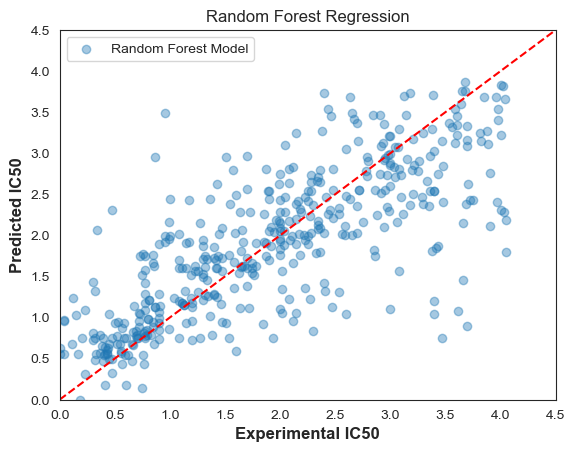

In [32]:
plt.scatter(Y_test, Y_pred_rf, alpha=0.4, label='Random Forest Model')
plt.plot([0, 6], [0, 6], color='red', linestyle='--') # Diagonal line for reference
plt.title('Random Forest Regression')
plt.xlabel('Experimental IC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted IC50', fontsize='large', fontweight='bold')
plt.xlim(0, 4.5)
plt.ylim(0, 4.5)
plt.legend()
plt.show()

In [34]:
pd.DataFrame({"real pIC50": Y_test, "predicted pIC50": Y_pred})

,real pIC50,predicted pIC50
2094,3.602060,2.646956
764,1.276462,0.825542
240,0.447158,0.706343
2032,3.430881,1.751549
564,0.912222,1.175416
...,...,...
529,0.863323,0.545517
2104,3.643453,3.676436
1617,2.462398,3.075564
457,0.778151,1.372727


#### Features importance

In [36]:
feature_importances = random_forest_model.feature_importances_
# Associate these importances with the original features
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance':feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance',ascending=False)
# Display the importance of features
feature_importance_df.head(10)

,Feature,Importance
69,MACCS_70,0.155032
100,MACCS_101,0.135440
42,MACCS_43,0.055952
97,MACCS_98,0.025804
79,MACCS_80,0.021800
62,MACCS_63,0.021553
90,MACCS_91,0.016381
131,MACCS_132,0.015847
126,MACCS_127,0.015459
65,MACCS_66,0.014443


## Gradient Boosting Tree Method

In [30]:
# Create Gradient Boosting Tree Model
gradient_boosting_model = GradientBoostingRegressor(random_state=42)
# Perform cross-validation for Gradient Boosting Tree (5-fold cross-validation)
cv_scores_gradient_boosting = cross_val_score(gradient_boosting_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_gradient_boosting = np.sqrt(-cv_scores_gradient_boosting)  # Convert negative root mean square error to positive
# -------- Print cross-validation results ----------------
print("Modelo: Gradient Boosting Tree")
print("Puntuaciones RMSE de validación cruzada:", cv_rmse_scores_gradient_boosting)
print("Promedio de puntuaciones RMSE de validación cruzada:", cv_rmse_scores_gradient_boosting.mean())

Modelo: Gradient Boosting Tree
Puntuaciones RMSE de validación cruzada: [0.75778123 0.80788715 0.7729147  0.72184332 0.75826831]
Promedio de puntuaciones RMSE de validación cruzada: 0.7637389411588483


In [31]:
# Create XGBoost model
xgboost_model = XGBRegressor(random_state=42)
# Perform cross-validation for XGBoost (5-fold cross-validation)
cv_scores_xgboost = cross_val_score(xgboost_model, X_train, Y_train, cv=5,scoring='neg_mean_squared_error')
cv_rmse_scores_xgboost = np.sqrt(-cv_scores_xgboost) # Convert the negative mean squared error to positive
# -------- Print cross-validation results --------------------------
print("Model: XGBoost")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_xgboost)
print("Mean CV RMSE Score:", cv_rmse_scores_xgboost.mean())

Model: XGBoost
Cross-Validation RMSE Scores: [0.68047924 0.77203616 0.73794531 0.70237516 0.73256867]
Mean CV RMSE Score: 0.7250809094132874


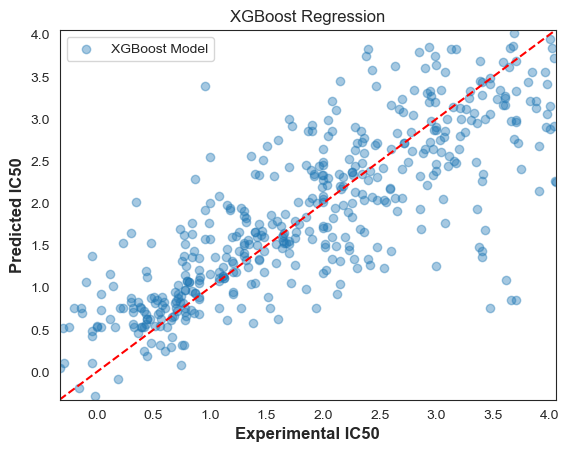

In [33]:
# Train the XGBoost model on the training set
xgboost_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_xgboost = xgboost_model.predict(X_test)

# Create a scatter plot to compare the actual and predicted IC50 values
plt.scatter(Y_test, Y_pred_xgboost, alpha=0.4, label='XGBoost Model')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--') # Diagonal line for reference
plt.title('XGBoost Regression')
plt.xlabel('Experimental IC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted IC50', fontsize='large', fontweight='bold')
plt.xlim([Y_test.min(), Y_test.max()])
plt.ylim([Y_test.min(), Y_test.max()])
plt.legend()
plt.show()

In [35]:
pd.DataFrame({"real pIC50": Y_test, "predicted pIC50": Y_pred_xgboost})

,real pIC50,predicted pIC50
2094,3.602060,3.165929
764,1.276462,0.756031
240,0.447158,1.119661
2032,3.430881,1.683182
564,0.912222,1.123372
...,...,...
529,0.863323,0.941243
2104,3.643453,3.608832
1617,2.462398,3.392248
457,0.778151,0.971021


After thorough evaluation, it was observed that their predictions were remarkably similar, with one model occasionally outperforming the other in specific instances. Given the similarity in performance and considering that Random Forest is a commonly preferred choice for QSAR tasks due to its versatility and robustness, the decision was made to proceed with Random Forest for the subsequent analysis.

# Prediction of compounds from Ligand Based Virtual Screening

In [37]:
similarity_df = pd.read_csv('filtered_compounds.csv')

In [38]:
similarity_df

,CanonicalSMILES,CID,MACCS,Morgan,Tanimoto_MACCS,Dice_MACCS,Tanimoto_Morgan,Dice_Morgan
0,C#CCN1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4...,153291518,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.900000,0.947368,0.575342,0.730435
1,C.C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=N...,161373040,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.857143,0.923077,0.554054,0.713043
2,C1=CC=C2C(=C1)C(=O)NN(C2=O)CCC(=O)NCCNC3=C(C(=...,55971589,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.848485,0.918033,0.269663,0.424779
3,C1=CC=C2C(=C1)C=NN(C2=O)CC(=O)N(CCC(=O)N)C3=CC...,133822628,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.859375,0.924370,0.172043,0.293578
4,C1=CC=C2C(=C1)C=NN(C2=O)CCNCCC(=O)NC3=CC(=CC(=...,167976678,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.846154,0.916667,0.184783,0.311927
...,...,...,...,...,...,...,...,...
713,CNC(=O)C1=NN(C(=O)C2=CC=CC=C21)CN3CCN(CC3)C4=C...,17521030,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.875000,0.933333,0.329268,0.495413
714,[C-]#[N+]C1=C(C=C(C=C1)F)N2CCN(CC2)C(=O)CCC3=C...,167326909,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.854839,0.921739,0.255556,0.407080
715,[C-]#[N+]C1=C(C=CC(=C1)F)N2CCN(CC2)C(=O)CCC3=C...,167326914,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.854839,0.921739,0.252747,0.403509
716,[CH3-].C1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O...,158381963,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.854839,0.921739,0.571429,0.727273


In [39]:
# Select only the CanonicalSMILES and CID columns.
selected_df = similarity_df[['CanonicalSMILES', 'CID']]
selected_df.head()

,CanonicalSMILES,CID
0,C#CCN1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4...,153291518
1,C.C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=N...,161373040
2,C1=CC=C2C(=C1)C(=O)NN(C2=O)CCC(=O)NCCNC3=C(C(=...,55971589
3,C1=CC=C2C(=C1)C=NN(C2=O)CC(=O)N(CCC(=O)N)C3=CC...,133822628
4,C1=CC=C2C(=C1)C=NN(C2=O)CCNCCC(=O)NC3=CC(=CC(=...,167976678


## MACSS calculation

In [40]:
maccs_ca_list = []
for smiles in selected_df['CanonicalSMILES']: # Iterate through the SMILES feature and calculate descriptors
    mol = Chem.MolFromSmiles(smiles)
    # Get MACCS fingerprints to get all 167 bits as X variables (descriptors)
    maccs_fingerprints = AllChem.GetMACCSKeysFingerprint(mol)
    maccs_ca_list.append(maccs_fingerprints)
df_maccs = pd.DataFrame(maccs_ca_list) # A df should be created with MACCS peptide fingerprint info
df_maccs

,0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
713,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
714,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
715,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
db_maccs_ca = pd.DataFrame(df_maccs[0].apply(list).tolist(),columns=[f'MACCS_{i+1}' for i in range(167)]) # Split MACCS fingerprint into individual columns
db_final = pd.concat([selected_df, db_maccs_ca], axis=1) # Merge balanced original dataframe with DF with the descriptors
db_final

,CanonicalSMILES,CID,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,MACCS_167
0,C#CCN1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4...,153291518,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
1,C.C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=N...,161373040,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
2,C1=CC=C2C(=C1)C(=O)NN(C2=O)CCC(=O)NCCNC3=C(C(=...,55971589,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
3,C1=CC=C2C(=C1)C=NN(C2=O)CC(=O)N(CCC(=O)N)C3=CC...,133822628,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
4,C1=CC=C2C(=C1)C=NN(C2=O)CCNCCC(=O)NC3=CC(=CC(=...,167976678,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,CNC(=O)C1=NN(C(=O)C2=CC=CC=C21)CN3CCN(CC3)C4=C...,17521030,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
714,[C-]#[N+]C1=C(C=C(C=C1)F)N2CCN(CC2)C(=O)CCC3=C...,167326909,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
715,[C-]#[N+]C1=C(C=CC(=C1)F)N2CCN(CC2)C(=O)CCC3=C...,167326914,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
716,[CH3-].C1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O...,158381963,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1


In [42]:
test = db_final.drop(columns=['CID','CanonicalSMILES'])
test

,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,MACCS_10,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,MACCS_167
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
714,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
715,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
716,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1


## Prediction

In [43]:
predictions = random_forest_model.predict(test)
PredictionDataset = pd.DataFrame({
'CID': db_final['CID'],
'Smiles': db_final['CanonicalSMILES'],
'Predicted_log(IC50)': predictions,
'Predicted IC50':10**(predictions)
})
PredictionDataset

,CID,Smiles,Predicted_log(IC50),Predicted IC50
0,153291518,C#CCN1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4...,1.623805,42.053796
1,161373040,C.C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=N...,1.029108,10.693216
2,55971589,C1=CC=C2C(=C1)C(=O)NN(C2=O)CCC(=O)NCCNC3=C(C(=...,1.228647,16.929615
3,133822628,C1=CC=C2C(=C1)C=NN(C2=O)CC(=O)N(CCC(=O)N)C3=CC...,1.473034,29.719010
4,167976678,C1=CC=C2C(=C1)C=NN(C2=O)CCNCCC(=O)NC3=CC(=CC(=...,1.834529,68.317110
...,...,...,...,...
713,17521030,CNC(=O)C1=NN(C(=O)C2=CC=CC=C21)CN3CCN(CC3)C4=C...,1.504425,31.946662
714,167326909,[C-]#[N+]C1=C(C=C(C=C1)F)N2CCN(CC2)C(=O)CCC3=C...,0.555657,3.594654
715,167326914,[C-]#[N+]C1=C(C=CC(=C1)F)N2CCN(CC2)C(=O)CCC3=C...,0.555657,3.594654
716,158381963,[CH3-].C1CCN(CC1)C(=O)C2=C(C=CC(=C2)CC3=NNC(=O...,1.586952,38.632386


In [44]:
filtered_and_sorted_compounds = PredictionDataset[PredictionDataset['Predicted IC50'] < 1.5].sort_values(by='Predicted IC50')

# Show the filtered and sorted DataFrame
len(filtered_and_sorted_compounds)

13

In [45]:
filtered_and_sorted_compounds

,CID,Smiles,Predicted_log(IC50),Predicted IC50
624,145960349,CC1=CC=C(C=C1)N2CCN(CC2)C(=O)C3=C(C(=CC(=C3)CC...,-0.288646,0.514463
179,154276338,C1CN(CC1F)CC2C3=CC=CC=C3CN2C(=O)NC4=CC=C(C=C4)...,-0.240279,0.575070
601,168279603,CC1=CC(=CC=C1)NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(C...,-0.080097,0.831578
625,168278040,CC1=CC=C(C=C1)NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(C...,-0.080097,0.831578
633,168273464,CC1=CC=CC=C1NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(CC3...,-0.080097,0.831578
232,168289818,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182
234,168283214,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182
235,168272772,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182
552,59535477,CC1=C(C(=O)NN=C1CC2=CC(=C(C=C2)F)C(=O)N3CCN(CC...,0.026735,1.063494
657,68498505,CCC1=CC(=NNC1=O)CC2=CC(=C(C=C2)F)C(=O)N3CCN(C(...,0.065821,1.163648


In [46]:
# Delete row containing 'query_control' in column 'Chembl_ID'
filtered_and_sorted_compounds = filtered_and_sorted_compounds[filtered_and_sorted_compounds['CID'] != 'query_control']

filtered_and_sorted_compounds


,CID,Smiles,Predicted_log(IC50),Predicted IC50
624,145960349,CC1=CC=C(C=C1)N2CCN(CC2)C(=O)C3=C(C(=CC(=C3)CC...,-0.288646,0.514463
179,154276338,C1CN(CC1F)CC2C3=CC=CC=C3CN2C(=O)NC4=CC=C(C=C4)...,-0.240279,0.575070
601,168279603,CC1=CC(=CC=C1)NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(C...,-0.080097,0.831578
625,168278040,CC1=CC=C(C=C1)NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(C...,-0.080097,0.831578
633,168273464,CC1=CC=CC=C1NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(CC3...,-0.080097,0.831578
232,168289818,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182
234,168283214,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182
235,168272772,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182
552,59535477,CC1=C(C(=O)NN=C1CC2=CC(=C(C=C2)F)C(=O)N3CCN(CC...,0.026735,1.063494
657,68498505,CCC1=CC(=NNC1=O)CC2=CC(=C(C=C2)F)C(=O)N3CCN(C(...,0.065821,1.163648


These are the 13 compounds for which the model has predicted an IC50 value less than 1.5. Therefore, it must now be checked that they comply with the ADMET properties.

## ADMET Properties

In [47]:
 #Define the descriptors to be analyzed
def calculate_ro5_properties(canonical_smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(canonical_smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) == 5 
    return pd.Series(
    [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
    index=['molecular_weight', 'n_hba', 'n_hbd', 'logp', 'TPSA', 'ro5_fulfilled'],
    )

In [51]:
# Calculate RO5 properties
ro5_properties = filtered_and_sorted_compounds['Smiles'].apply(calculate_ro5_properties)
ro5_properties

,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
624,474.186732,4,1,4.06292,69.30,True
179,483.207053,4,2,4.72270,81.33,True
601,618.239082,5,3,5.20362,127.50,False
625,618.239082,5,3,5.20362,127.50,False
633,618.239082,5,3,5.20362,127.50,False
232,622.214010,5,3,5.03430,127.50,False
234,622.214010,5,3,5.03430,127.50,False
235,622.214010,5,3,5.03430,127.50,False
552,438.186732,4,1,3.21814,69.30,True
657,434.175419,4,1,2.55120,86.37,True


In [52]:
balanced_df= pd.concat([filtered_and_sorted_compounds, ro5_properties], axis=1)
balanced_df

,CID,Smiles,Predicted_log(IC50),Predicted IC50,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
624,145960349,CC1=CC=C(C=C1)N2CCN(CC2)C(=O)C3=C(C(=CC(=C3)CC...,-0.288646,0.514463,474.186732,4,1,4.06292,69.30,True
179,154276338,C1CN(CC1F)CC2C3=CC=CC=C3CN2C(=O)NC4=CC=C(C=C4)...,-0.240279,0.575070,483.207053,4,2,4.72270,81.33,True
601,168279603,CC1=CC(=CC=C1)NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(C...,-0.080097,0.831578,618.239082,5,3,5.20362,127.50,False
625,168278040,CC1=CC=C(C=C1)NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(C...,-0.080097,0.831578,618.239082,5,3,5.20362,127.50,False
633,168273464,CC1=CC=CC=C1NC(=O)C2=CC=C(C=C2)NC(=O)N3CCN(CC3...,-0.080097,0.831578,618.239082,5,3,5.20362,127.50,False
232,168289818,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182,622.214010,5,3,5.03430,127.50,False
234,168283214,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182,622.214010,5,3,5.03430,127.50,False
235,168272772,C1CN(CCN1C(=O)C2=C(C=CC(=C2)CC3=NNC(=O)C4=CC=C...,-0.001226,0.997182,622.214010,5,3,5.03430,127.50,False
552,59535477,CC1=C(C(=O)NN=C1CC2=CC(=C(C=C2)F)C(=O)N3CCN(CC...,0.026735,1.063494,438.186732,4,1,3.21814,69.30,True
657,68498505,CCC1=CC(=NNC1=O)CC2=CC(=C(C=C2)F)C(=O)N3CCN(C(...,0.065821,1.163648,434.175419,4,1,2.55120,86.37,True


I have filtered to keep those compounds that comply with all the rules.

In [53]:
filtered_df = balanced_df[balanced_df['ro5_fulfilled'] == True]

idx = filtered_df.groupby('Smiles')['Predicted IC50'].idxmin()

final_df = filtered_df.loc[idx]

In [54]:
final_df

,CID,Smiles,Predicted_log(IC50),Predicted IC50,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
174,71606888,C1CN(C2CNC(=O)C3=CC=CC1=C23)C(=O)C4=C(C=CC(=C4...,0.148475,1.407587,468.159769,4,2,3.13600,95.16,True
179,154276338,C1CN(CC1F)CC2C3=CC=CC=C3CN2C(=O)NC4=CC=C(C=C4)...,-0.240279,0.575070,483.207053,4,2,4.72270,81.33,True
403,145952366,C1CN(CCN1C2=CC=CC=C2O)C(=O)C3=C(C(=CC(=C3)CC4=...,0.118806,1.314636,476.165997,5,2,3.46010,89.53,True
552,59535477,CC1=C(C(=O)NN=C1CC2=CC(=C(C=C2)F)C(=O)N3CCN(CC...,0.026735,1.063494,438.186732,4,1,3.21814,69.30,True
553,59535475,CC1=C(C(=O)NN=C1CC2=CC(=C(C=C2)F)C(=O)N3CCN(CC...,0.135411,1.365874,426.243104,4,1,3.20714,69.30,True
624,145960349,CC1=CC=C(C=C1)N2CCN(CC2)C(=O)C3=C(C(=CC(=C3)CC...,-0.288646,0.514463,474.186732,4,1,4.06292,69.30,True
657,68498505,CCC1=CC(=NNC1=O)CC2=CC(=C(C=C2)F)C(=O)N3CCN(C(...,0.065821,1.163648,434.175419,4,1,2.55120,86.37,True


After predicting IC50 values using the QSAR model and filtering for values below 1.5 nM, followed by the assessment of ADMET properties compliance, a total of 7 potential compounds have emerged as candidates for the final stage of the pipeline. These compounds exhibit excellent predicted inhibitory capabilities and adhere to ADMET rules. Consequently, their interaction with the target protein, as well as their affinity, will be thoroughly investigated through docking studies. This additional filtration step aims to identify the most promising candidates as potential inhibitors of PARP1.

In [55]:
# Select only the 'CID' and 'Smiles' columns
reduced_df = final_df[['CID', 'Smiles']]

In [57]:
# Export the DataFrame to a TXT file
reduced_df.to_csv('reduced_df.txt', sep=',', index=False)